# Dataset Link:

https://data.mendeley.com/datasets/32b5vfj6tc/1

# Import Library

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
print(device)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU Only")


cuda
Device: NVIDIA GeForce RTX 3060 Laptop GPU


# Preprocessing

In [ ]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    "val_test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}


# Dataset

In [4]:
# data_dir = 'dataset'
# full_dataset = ImageFolder(root=data_dir, transform=transform['train'])

# train_size = int(0.7 * len(full_dataset))
# val_size = int(0.15 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(
#     full_dataset, [train_size, val_size, test_size],
#     generator=torch.Generator().manual_seed(42)
# )

# val_dataset.dataset.transform = transform['val_test']
# test_dataset.dataset.transform = transform['val_test']
# batch_size = 16

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [5]:
# 3. Load Dataset dan Split
data_dir = "datasets"  # folder dengan subfolder `defective/` dan `normal/`
dataset = ImageFolder(root=data_dir, transform=transform["train"])

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
val_data.dataset.transform = transform["val_test"]
test_data.dataset.transform = transform["val_test"]

# DataLoader
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [6]:
print(f"Total data: {len(dataset)}")
print(f"Training data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Total data: 1698
Training data: 1188
Validation data: 254
Test data: 256


# Model

In [7]:
# 4. Load EfficientNet-B7 Pretrained
from torchvision.models import densenet121, DenseNet121_Weights
from torchinfo import summary
weights = DenseNet121_Weights.DEFAULT
model = densenet121(weights=weights)

# Freeze all pretrained layers
# for param in model.parameters():
#     param.requires_grad = False

# Replace classifier head
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)  # 2 classes: defective, normal
)

model = model.to(device)
summary(model, input_size=(1, 3, 224, 224))  

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 2]                    --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

In [8]:
# from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
# from torchsummary import summary

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze backbone

# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
# model = model.to(device)

# summary(model, input_size=(3, 600, 600))

# Parameter


In [9]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 50



In [10]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [11]:
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()

    val_acc = correct_val / len(val_data)

    # Simpan history
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "densenet.pth")


Epoch 1: Train Loss = 34.1149, Val Loss = 4.1742, Train Acc = 0.8039, Val Acc = 0.9252
Epoch 2: Train Loss = 19.7267, Val Loss = 3.2748, Train Acc = 0.8990, Val Acc = 0.9449
Epoch 3: Train Loss = 17.1820, Val Loss = 3.3478, Train Acc = 0.9032, Val Acc = 0.9094
Epoch 4: Train Loss = 17.6560, Val Loss = 2.7550, Train Acc = 0.9125, Val Acc = 0.9409
Epoch 5: Train Loss = 15.5406, Val Loss = 2.7210, Train Acc = 0.9242, Val Acc = 0.9449
Epoch 6: Train Loss = 17.8069, Val Loss = 2.5639, Train Acc = 0.9015, Val Acc = 0.9409
Epoch 7: Train Loss = 16.6784, Val Loss = 2.5453, Train Acc = 0.9116, Val Acc = 0.9449
Epoch 8: Train Loss = 15.3098, Val Loss = 2.4968, Train Acc = 0.9167, Val Acc = 0.9370
Epoch 9: Train Loss = 15.8661, Val Loss = 2.6626, Train Acc = 0.9242, Val Acc = 0.9331
Epoch 10: Train Loss = 14.6352, Val Loss = 2.3213, Train Acc = 0.9200, Val Acc = 0.9449
Epoch 11: Train Loss = 15.5126, Val Loss = 2.3100, Train Acc = 0.9192, Val Acc = 0.9449
Epoch 12: Train Loss = 15.6974, Val Loss 

# Evaluation

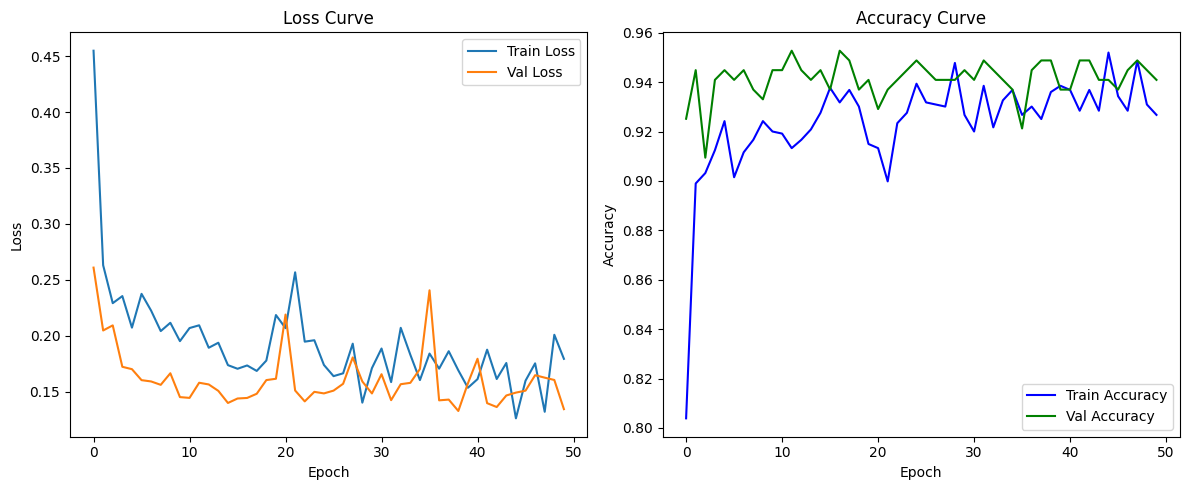

In [12]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# 7. Evaluasi di Test Set
model.load_state_dict(torch.load("densenet.pth"))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.9531



Classification Report:

              precision    recall  f1-score   support

   Defective       0.97      0.94      0.96       136
        Good       0.94      0.97      0.95       120

    accuracy                           0.95       256
   macro avg       0.95      0.95      0.95       256
weighted avg       0.95      0.95      0.95       256



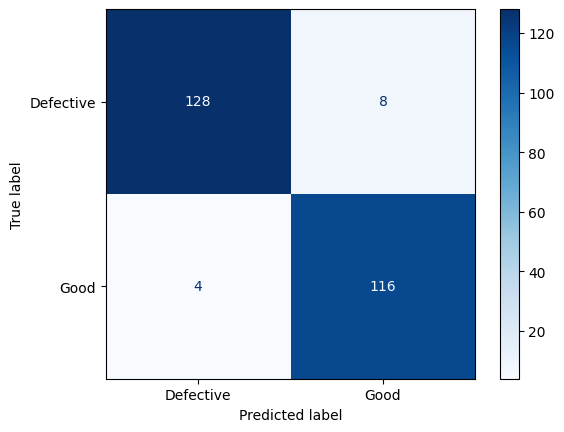

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Kumpulkan semua label dan prediksi
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


In [15]:
# 8. Prediksi Gambar Baru
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform_fn = transform["val_test"]
    image_tensor = transform_fn(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred = output.argmax(dim=1).item()
    return dataset.classes[pred]

# Contoh penggunaan
image_path = r"TestModel\images.jfif"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)


Predicted: Defective


In [16]:
image_path = r"TestModel/rusak2.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

Predicted: Good


In [17]:
image_path = r"TestModel\rusak1.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

Predicted: Good


In [18]:
image_path = r"TestModel\apik1.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

Predicted: Good


In [19]:
image_path = r"TestModel\apik2.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

Predicted: Good


In [20]:
image_path = r"TestModel\rusak12.webp"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

Predicted: Defective
